In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
%matplotlib inline


In [3]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image


In [4]:
from imageai.Detection.Custom import CustomObjectDetection

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()

In [5]:
from src.settings import *
from src.data import get_image_value
from src.data import get_file_list
from src.data import extract_roi
from src.utils import show_result_img
from src.utils import disply_heatmap

In [6]:
max_idx = 45
sample_file_list = [f'./data/images/samples/s{i}.jpg' for i in range(0,max_idx)]
input_img = []
for i in range(0,max_idx):
    input_img.append(cv2.imread(sample_file_list[i]))

In [7]:
detect_model_folder = f"./data/images/box/models/"
class_model_folder = f"./data/models/mobilnet/"
ignore_file = '.ipynb_checkpoints'
json_path = './data/images/box/json/detection_config.json'

In [8]:

def model_load(detection_model_path,
               json_path,
               cls_model_path,):
    
    detector = CustomObjectDetection()
    detector.setModelTypeAsYOLOv3()
    
    detector.setModelPath(detection_model_path) 
    detector.setJsonPath(json_path)
    detector.loadModel()
    
    model = tf.keras.models.load_model(cls_model_path)
    
    return detector, model


def detect_misprinted_label(img,
                            detector, 
                            model,
                            img_show = True):
    
    img = img.copy()
    start_tm = time.time()
    _, detections = detector.detectObjectsFromImage(input_image=img,
                                                   input_type='array',
                                                   output_type='array')
                                                 
    
    #print ("Detection time : {:.2f}s".format(time.time() - start_tm))
    results = []
    if len(detections)>0:
        roi_list = extract_roi(img, detections)
        
        pred = model.predict(np.array(roi_list))
        
        out_img, results = show_result_img(img, pred, detections, img_show=img_show)
    else:
        out_img = img
        
    return out_img, results
    

In [9]:
detect_model_list = os.listdir(detect_model_folder)
if ignore_file in detect_model_list:
    idx = detect_model_list.index(ignore_file)
    detect_model_list.pop(idx)

In [10]:
cls_model_list = os.listdir(class_model_folder)
if ignore_file in cls_model_list:
    idx = cls_model_list.index(ignore_file)
    cls_model_list.pop(idx)

In [11]:
def return_acc(true, pred):
    
    obj_list = []
    acc_list = []
    dec_list = []
    for idx, item in enumerate(pred):
        pred_obj = item
        true_obj = true[idx]
        obj_list.append(len(true_obj))
        dec_list.append(len(pred_obj))
        for i, t in enumerate(true_obj):
            if i < len(pred_obj):
                if t == pred_obj[i]:
                    acc_list.append(1)
                else:
                    acc_list.append(0)
            #else:
            #    acc_list.append(0)
    
    print (f"Acc : {np.mean(acc_list)*100:.2f}%, Detected obj : {np.sum(dec_list)}")
    return acc_list, dec_list, obj_list 
#_, _, _ = return_acc(true_dic, result_class)

In [21]:
last_conv_layer_name = 'HeatLayer'

def activation_map(detector,
                   model,  
                   img,
                   last_conv_layer_name,
                   pixels = 0):
    
    image_h, image_w, _ = img.shape
    
    img = img.copy()
    _, detections = detector.detectObjectsFromImage(input_image=img,
                                                   input_type='array',
                                                   output_type='array')
    
    
    results = []
    heat_list = []
    if len(detections)>0:
        roi_list = extract_roi(img, detections)
        
        pred = model.predict(np.array(roi_list))
        
        roi_array = extract_roi(img, detections, pixels=pixels)
        for roi, det, prob in zip(roi_array, detections, np.reshape(pred, (len(pred)))):
            if prob > 0.5:
                txt = 'true'
            else:
                txt = 'false'
            xmin, ymin, xmax, ymax = det['box_points']
            h = ymax-ymin
            w = xmax-xmin
            heat_img = disply_heatmap(roi, model, last_conv_layer_name)
            heat_img = heat_img.resize((w+2*pixels, h+2*pixels))
            heat_img = image.img_to_array(heat_img).astype('int')
            heat_list.append(heat_img)
            xmin = max(0, xmin-pixels)
            ymin = max(0, ymin-pixels)
            xmax = min(image_w, xmax+pixels)
            ymax = min(image_h, ymax+pixels)
            img[ymin:ymax,xmin:xmax,:] = heat_img[:ymax-ymin,:xmax-xmin,:]
            if txt == 'true':
                rgb = (0,0,255) # Blue 
            else:
                rgb = (255,0,0) # Red
                prob = 1-prob
            txt = f'{txt} : {prob:.2f}'

            cv2.rectangle(img, (xmin, ymin), (xmax, ymax),
                          rgb, 4)
            text_y = ymin - 15 if ymin - 15 > 15 else ymin + 15
            cv2.putText(img, txt, (xmin, text_y),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, rgb, 2)
        
    
    return heat_list, detections, img
    

In [22]:


def run(detector_model_path, json_path, cls_model_path, img_show = True, heat_show = False):
    detector, model = model_load(detector_model_path,
                             json_path,
                             cls_model_path)
    
    result_img = []
    result_class = []

    for i in range(len(input_img)):
        #print (f'{i}')
        out_img, out_cls = detect_misprinted_label(input_img[i], detector, model, img_show = False)
        if heat_show:
            _, _, out_img = activation_map(detector, model, input_img[i], last_conv_layer_name)
        result_img.append(out_img)
        result_class.append(out_cls)
        
    print (detector_model_path)
    print (cls_model_path)
    if img_show : 
        max_row = 15
        max_col = 3
        fig, ax = plt.subplots(max_row, max_col, figsize=(20,100), dpi=80)
        for i in range(max_row*max_col):
            rw = int(i/max_col)
            cl = i%max_col
            #print (i, rw, cl)
            ax[rw, cl].axis('off')
            ax[rw, cl].imshow(result_img[i])
    
    _, _, _ = return_acc(TRUE_DIC, result_class)
    
    return result_class

./data/images/box/models/detection_model-ex-023--loss-0016.847.h5
./data/models/mobilnet/mobilenet_batch_add_conv_16_lr_0.0005_.h5
Acc : 80.25%, Detected obj : 82


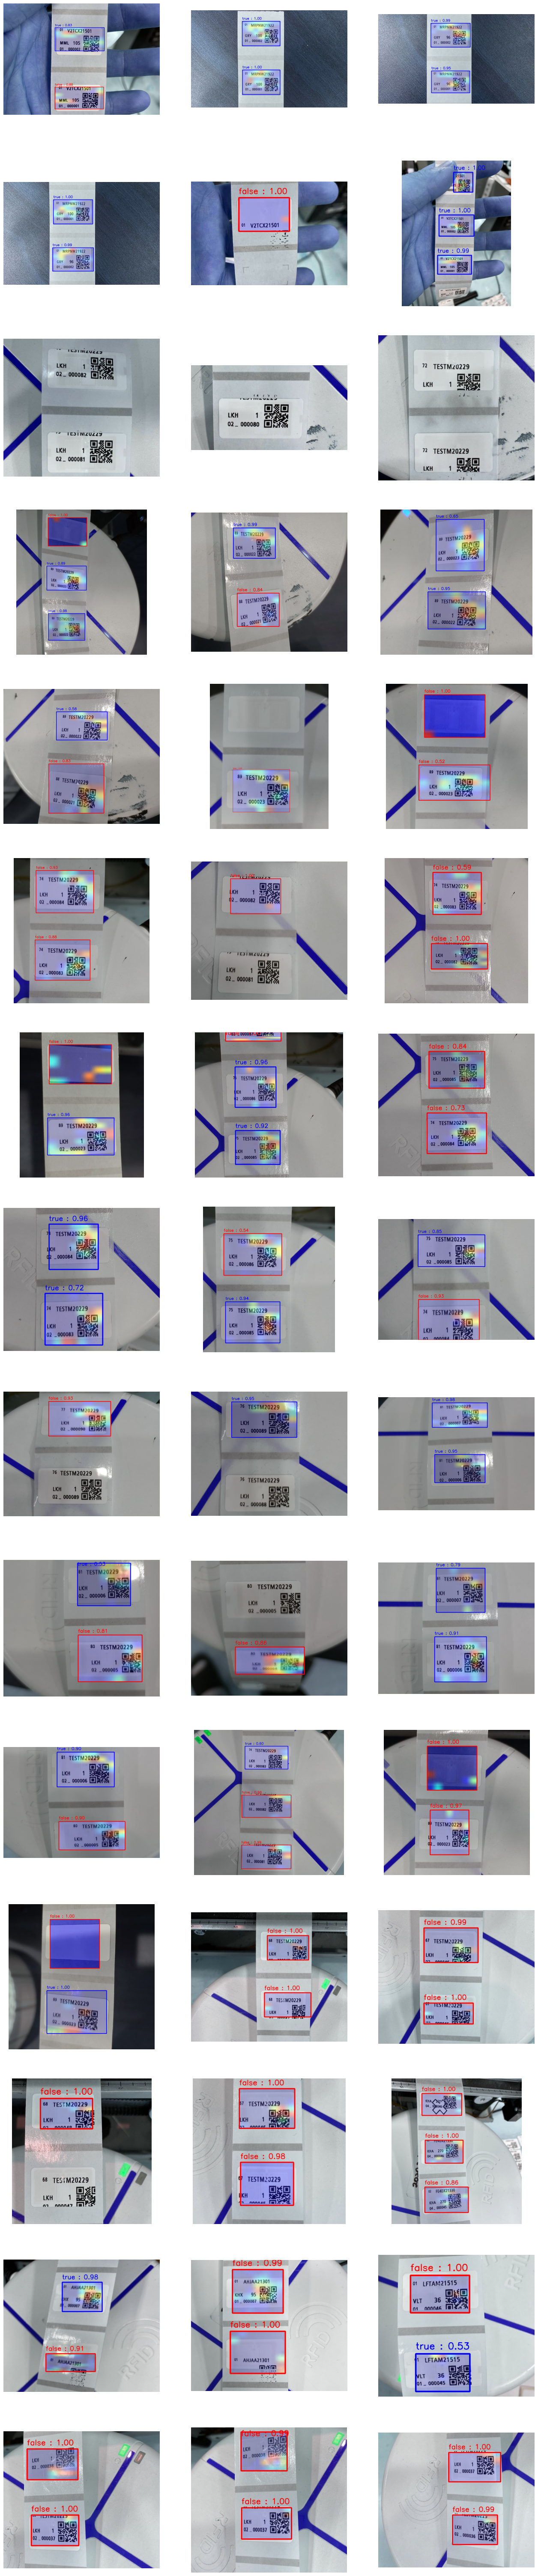

In [23]:
detector_model_path = f"./data/images/box/models/detection_model-ex-023--loss-0016.847.h5"
cls_model_name = './data/models/mobilnet/mobilenet_batch_add_conv_16_lr_0.0005_.h5'

result_class = run(detector_model_path, json_path, cls_model_name, img_show = True, heat_show=True)

In [ ]:
detector_model_path = f"./data/images/box/models/detection_model-ex-023--loss-0016.847.h5"

for cls_file in cls_model_list:
    result_class = run(detector_model_path, json_path, os.path.join(class_model_folder,cls_file), False)

In [24]:
cls_model_name = './data/models/mobilnet/mobilenet_batch16_lr_0.001_val_loss_0.24776.h5'
for dtc_file in detect_model_list:
    result_class = run(os.path.join(detect_model_folder, dtc_file), json_path, cls_model_name, False)

./data/images/box/models/detection_model-ex-052--loss-0010.760.h5
./data/models/mobilnet/mobilenet_batch16_lr_0.001_val_loss_0.24776.h5
Acc : 87.50%, Detected obj : 64
./data/images/box/models/detection_model-ex-032--loss-0014.714.h5
./data/models/mobilnet/mobilenet_batch16_lr_0.001_val_loss_0.24776.h5
Acc : 81.82%, Detected obj : 66
./data/images/box/models/detection_model-ex-030--loss-0010.144.h5
./data/models/mobilnet/mobilenet_batch16_lr_0.001_val_loss_0.24776.h5
Acc : 82.81%, Detected obj : 64
./data/images/box/models/detection_model-ex-033--loss-0010.930.h5
./data/models/mobilnet/mobilenet_batch16_lr_0.001_val_loss_0.24776.h5
Acc : 86.15%, Detected obj : 65
./data/images/box/models/detection_model-ex-023--loss-0016.847.h5
./data/models/mobilnet/mobilenet_batch16_lr_0.001_val_loss_0.24776.h5
Acc : 83.95%, Detected obj : 82
./data/images/box/models/detection_model-ex-036--loss-0014.921.h5
./data/models/mobilnet/mobilenet_batch16_lr_0.001_val_loss_0.24776.h5
Acc : 89.23%, Detected o

/home/jupyter/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jupyter/.local/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


./data/images/box/models/detection_model-ex-017--loss-0016.448.h5
./data/models/mobilnet/mobilenet_batch16_lr_0.001_val_loss_0.24776.h5
Acc : 88.06%, Detected obj : 68


./data/images/box/models/detection_model-ex-023--loss-0016.736.h5
./data/models/mobilnet/mobilenet_val_loss_0.0756.h5
Acc : 61.70%, Detected obj : 66


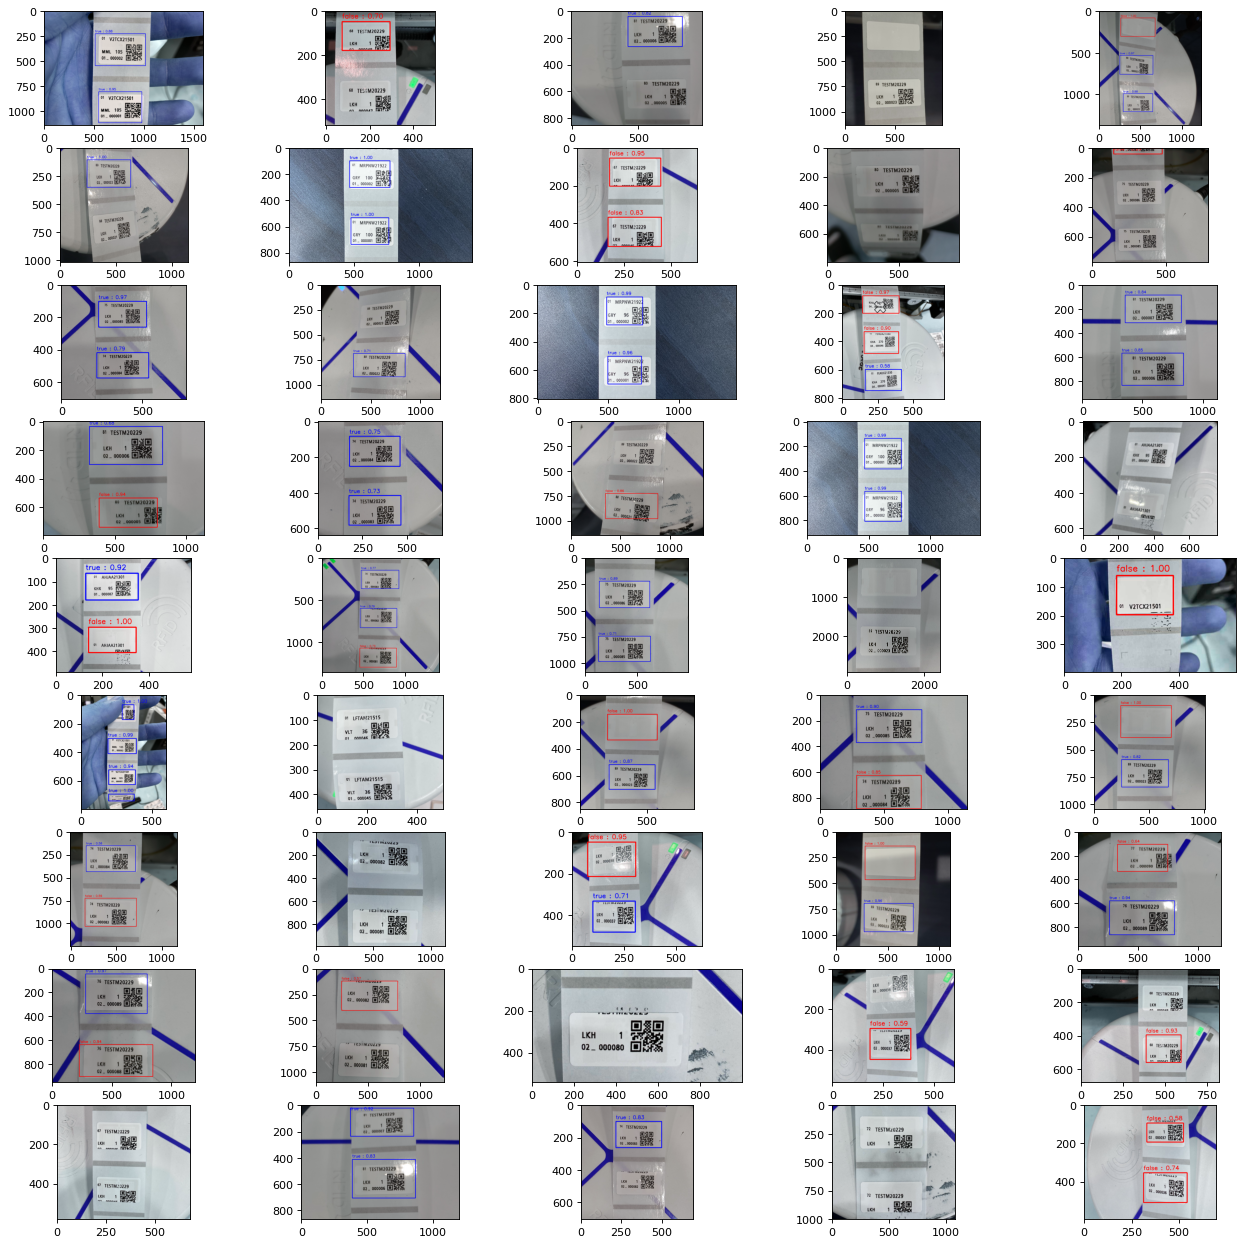

In [15]:
detector_model_path = f"./data/images/box/models/detection_model-ex-023--loss-0016.736.h5"
cls_model_path = f"./data/models/mobilnet/mobilenet_val_loss_0.0756.h5"
result_class = run(detector_model_path, json_path, cls_model_path)